In [1]:
%load_ext autoreload
%autoreload 1
%aimport dlqmc.nn, dlqmc.sampling, dlqmc.utils
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = \
    {'bbox_inches': 'tight', 'dpi': 300}

In [2]:
import numpy as np
from scipy import special
import scipy.stats as sps
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.distributions import Normal
from pyscf import gto, scf, dft
import pyscf
from pyscf.data.nist import BOHR
import time
from functools import partial
from tqdm.auto import tqdm, trange

from dlqmc.nn import WFNet
from dlqmc.nn import *
from dlqmc.sampling import langevin_monte_carlo, hmc ,samples_from, metropolis
from dlqmc.utils import (
    plot_func, get_flat_mesh, assign_where, plot_func_xy,
    plot_func_x, integrate_on_mesh, assign_where
)
from dlqmc.physics import (
    local_energy, grad, quantum_force,nuclear_potential,
    nuclear_energy, laplacian, electronic_potential
)
from dlqmc.geom import *
from dlqmc.gto import GTOWF
from dlqmc.analysis import autocorr_coeff, blocking
from dlqmc.nn import ssp

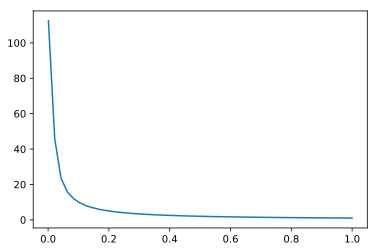

In [3]:
plot_func_x(lambda x: special.erf(x/0.01)/x,(1e-3, 1));

In [4]:
x_line = torch.cat((torch.linspace(-3, 3, 500)[:, None], torch.zeros((500, 5))), dim=1)
x_line=x_line.view(-1,2,3)
#mesh = get_3d_cube_mesh([(-6, 6), (-4, 4), (-4, 4)], [600, 400, 400])

In [5]:
x_line.shape

torch.Size([500, 2, 3])

In [6]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -0.602622271479773


-0.6026222714797727

## Net WF

In [7]:
#H2+     Energy = -0.6023424   for R = 1.9972
#fit(batch_size=10000, n_el=1, steps=500, epochs=1, RR=[[-1, 0, 0], [1., 0, 0]])

#H2		 Energy = -1.173427    for R = 1.40
#fit(batch_size=10000,n_el=2,steps=100,epochs=5,RR=torch.tensor([[-0.7,0,0],[0.7,0,0]]))

#He+	 Energy = -1.9998
#fit(batch_size=10000,n_el=1,steps=100,epochs=5,RR=torch.tensor([[0.,0,0]]),RR_charges=[2])

#He		 Energy = −2.90338583
#fit(batch_size=10000,n_el=2,steps=300,epochs=5,RR=torch.tensor([[0.3,0,0]]),RR_charges=[2])

In [8]:
h2p = Geometry([[-1., 0., 0.], [1., 0., 0.]], [1., 1.])
print(h2p)

In [9]:
import torch.nn as nn
class TestNet(nn.Module):
    def __init__(self, eps=0.01):
        super(TestNet, self).__init__()
        self.eps=eps
        self.NN1=nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 1)
            )
        self.NN2=nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 64),
            torch.nn.ELU(),
            torch.nn.Linear(64, 1)
            )
        self.alpha=nn.Parameter(torch.Tensor([10]))
        
    def forward(self,x,R=h2p.coords):
        if x.shape==(x.shape[0],3):
            x = x.view([-1,1,3])
        
        d = torch.zeros(len(x),2)
        d[:,0] = torch.norm(x-R[0],dim=[1,2])
        d[:,1] = torch.norm(x-R[1],dim=[1,2])
       # r = torch.erf(d / self.eps) / d
        #return self.NN1(d).flatten()*(torch.exp(-torch.abs(self.alpha)*d[:,0])+torch.exp(-torch.abs(self.alpha)*d[:,1]))+ self.NN2(r).flatten()
        return self.NN1(d).flatten()*(torch.exp(-d[:,0])+torch.exp(-d[:,1]))#+ self.NN2(r).flatten()


In [10]:
class WFNet(nn.Module):
    def __init__(
        self, geom, n_electrons, net, net_pair, ion_pot=0.5, cutoff=10.0, n_dist_feats=32, alpha=1.0
    ):
        super().__init__()
        self.dist_basis = DistanceBasis(n_dist_feats)
        self.nuc_asymp = NuclearAsymptotic(geom.charges, ion_pot, alpha=alpha)
        self.geom = geom
        n_atoms = len(geom.charges)
        n_pairs = n_electrons * n_atoms + n_electrons * (n_electrons - 1) // 2
        self.deep_lin = nn.Sequential(
            nn.Linear(n_pairs * n_dist_feats, 64),
            SSP(),
            nn.Linear(64, 64),
            SSP(),
            nn.Linear(64, 1),
        )
        self.antisym = AntisymmetricPart(net,net_pair)
        self._pdist = PairwiseDistance3D()
        self._psdist = PairwiseSelfDistance3D()

    def _featurize(self, rs):
        dists_nuc = self._pdist(rs, self.geom.coords[None, ...])
        dists_el = self._psdist(rs)
        dists = torch.cat([dists_nuc.flatten(start_dim=1), dists_el], dim=1)
        xs = self.dist_basis(dists).flatten(start_dim=1)
        return xs, (dists_nuc, dists_el)

    def forward(self, rs):
        xs, (dists_nuc, dists_el) = self._featurize(rs)
        ys = self.deep_lin(xs).squeeze(dim=1)
        return torch.exp(ys) * self.nuc_asymp(dists_nuc) * self.antisym(rs)


In [11]:
class Net_pair(nn.Module):
    def __init__(self):
        super().__init__()

        self.NN1=nn.Sequential(
            torch.nn.Linear(5, 10),
            SSP(),
            torch.nn.Linear(10, 20),
            SSP(),
            torch.nn.Linear(20, 30)
            )
        
    def forward(self,x1,x2,R=h2p.coords):
       
        d = torch.zeros(len(x1),5)
        d[:,0] = torch.norm(x1-R[0],dim=[1])
        d[:,1] = torch.norm(x1-R[1],dim=[1])
        d[:,2] = torch.norm(x2-R[0],dim=[1])
        d[:,3] = torch.norm(x2-R[1],dim=[1])
        d[:,4] = torch.norm(x1-x2,dim=[1])
        
        r  = torch.erf(d / 0.1) / d
        
        return self.NN1(r).view(-1,30)
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.NN1=nn.Sequential(
            torch.nn.Linear(30, 64),
            SSP(),
            torch.nn.Linear(64, 64),
            SSP(),
            torch.nn.Linear(64, 1)
            )
        
    def forward(self,x,R=h2p.coords):
        return self.NN1(x).flatten()

    


In [16]:
class NetPairwiseAntisymmetry(nn.Module):
    def __init__(self, net_pair):
        super().__init__()
        self.net_pair = net_pair

    def forward(self, x_i, x_j):
        return self.net_pair(x_i,x_j) - self.net_pair(x_j,x_i)

class NetOdd(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, x):
        return self.net(x)-(self.net(-x))
    
class AntisymmetricPart(nn.Module):
    def __init__(self, net, net_pair):
        super().__init__()
        self.net_pair_anti = NetPairwiseAntisymmetry(net_pair)
        self.latentdim = list(net.parameters())[0].shape[1]
        self.net_odd = NetOdd(net)
        
    def forward2(self, x):
        n = x.shape[-2]
        a = torch.ones(30)
        for i in range(n):
            for j in range(i):
                a = a * self.net_pair_anti(x[:,i],x[:,j])
        return self.net_odd(a)
    
    def forward(self, x):
        i, j = np.triu_indices(x.shape[-2], k=1)
        return self.net_odd(torch.prod(self.net_pair_anti(x[:,j].view(-1,3),x[:,i].view(-1,3)).view(-1,len(i),self.latentdim),dim=1))


In [13]:
#T=torch.tensor([[[1,2,3],[4,5,6.],[7,8,9]],[[1,2,3],[4,5,6.],[7,8,9]],[[1,2,3],[4,5,6.],[7,8,9]]])
#print(T.shape)
#print(T.reshape(-1,3)-np.tile(T[:,0],2).reshape(-1,3))
#print(T.reshape(-1,3)-np.tile(T[:,1],2).reshape(-1,3))

#(torch.Tensor.repeat(T,[1,3,1]).view(-1,3)-torch.Tensor.repeat(T,[1,1,3]).view(-1,3)).view([3,3,3,3])

In [48]:
str(Net())

'Net(\n  (NN1): Sequential(\n    (0): Linear(in_features=30, out_features=64, bias=True)\n    (1): SSP(beta=1, threshold=20)\n    (2): Linear(in_features=64, out_features=64, bias=True)\n    (3): SSP(beta=1, threshold=20)\n    (4): Linear(in_features=64, out_features=1, bias=True)\n  )\n)'

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)


KeyboardInterrupt: 

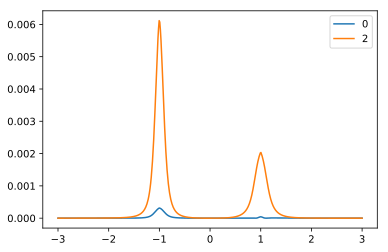

In [36]:
Onet = Net()
Pnet = Net_pair()
net = WFNet(h2p,2,Onet,Pnet)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
A = AntisymmetricPart(Onet,Pnet)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.995)


scale = 3
steps = 10

for i_step in range(steps):
    
    if i_step%(steps//4) == 0 or i_step==steps:
        Psi2 = net(x_line)**2
        plt.plot(x_line[:,0 , 0].detach().numpy(), Psi2.detach().numpy(),label=i_step)
    
    #scheduler.step()
    r = scale*torch.randn(2_000,2,3,requires_grad=True)
    
    pr = torch.from_numpy(sps.norm.pdf(np.linalg.norm(r.detach().numpy(),axis=1),scale=scale)).type(torch.FloatTensor)
    
    print(A.forward(r)-A.forward2(r))
    
    loss = torch.mean(net(r)**2*(nuclear_potential(r,h2p)+electronic_potential(r)) - laplacian(r,net)[0]*net(r))/torch.mean(net(r)**2) + (1-torch.mean(net(r)**2))**2
    #loss = torch.mean(local_energy(r,net,h2p)[0])
    
    #loss = torch.mean(net(r)**2)
    
 

    loss.backward()
    #torch.nn.utils.clip_grad_norm_(net.parameters(),10)
    opt.step()
    opt.zero_grad()
    
    plt.legend()


In [ ]:
x_line.requires_grad = True
Psi2 = net(x_line)**2
grad = torch.autograd.grad(Psi2,x_line,torch.ones_like(Psi2))[0]
plt.plot(x_line[:,0 , 0].detach().numpy(), Psi2.detach().numpy())
#plt.plot(x_line[:, 0].detach().numpy(), grad[:,0].detach().numpy())
#plt.ylim(-1,2)
x_line.requires_grad = False

In [ ]:
plt.plot(
    x_line[:, 0, 0].numpy(),
    local_energy(x_line,lambda x: net(x), h2p)[0].detach().numpy()
)
plt.ylim((-100, 10));

In [ ]:
t=time.time()
sampler = hmc(
    net,
    torch.randn(1000, 2, 3, device='cpu'),
    dysteps=5,
    stepsize=0.1
)
samples = samples_from(sampler,range(500))[0].flatten(end_dim=1)
print("it took: "+str(time.time()-t))

In [ ]:
plt.hist2d(
    samples[:,0, 0].detach().numpy(),
    samples[:,0, 1].detach().numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [ ]:
t=time.time()
sampler = metropolis(
    net,
    torch.randn(100, 1, 3, device='cpu'),
    stepsize=1
)
samples = samples_from(sampler,range(1000))[0].view(-1,3)
print("it took: "+str(time.time()-t))

In [ ]:
plt.hist2d(
    samples[:, 0].detach().numpy(),
    samples[:, 1].detach().numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [ ]:
t=time.time()
sampler = langevin_monte_carlo(
    net,
    torch.randn(1000, 2, 3, device='cpu'),
    tau=0.1,
)
samples = samples_from(sampler,range(500))[0].flatten(end_dim=1)
print("it took: "+str(time.time()-t))

In [ ]:
samples.shape

In [ ]:
plt.hist2d(
    samples[:,0, 0].detach().numpy(),
    samples[:,0, 1].detach().numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [ ]:
E_loc = local_energy(samples.view([-1,1,3]), lambda x: net(x), h2p)[0]

In [ ]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [ ]:
E_loc.mean().item()